In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import pulp

if 'project2' in os.getcwd():
    os.chdir('..')
    
from data.parse import *
from project2.uta.uta import UTA
from project2.uta.uta_plotting import plot_marginal_value_functions, get_ranking
from project2.kendall import *

***
# UTA

The entire UTA method is implemented outside this notebook, so that it is more readable. `UTAresults` are artifacts from every step of the algorithm (automated inconsistency resolvance + end-to-end execution on consistent data). For verification of our implementation we refer to `project2/uta/uta.py`. In general, we implemented everything that was in the instruction.

In [2]:
UTAresults = UTA()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ignacy/miniconda3/envs/putenv/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/e1b7f1c247c84ab39fede90763209096-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/e1b7f1c247c84ab39fede90763209096-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 143 COLUMNS
At line 796 RHS
At line 935 BOUNDS
At line 1002 ENDATA
Problem MODEL has 138 rows, 198 columns and 552 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 89 (-49) rows, 95 (-103) columns and 306 (-246) elements
Perturbing problem by 0.001% of 1 - largest nonzero change 1.0954017e-06 ( 0.00010954017%) - largest zero change 1.0803902e-06
0  Obj 1.9701789e-07 Primal inf 2.02677 (30)
31  Obj 3.8953863e-06 Primal inf 0.142687 (13)
65  Obj 0.018004527
Optimal - objective value 0.018
After Postsolve, objective 0.018, infeasibil

### UTA 2.1

Enriched pairwise comparisons:

In [3]:
pairwise_comparisons_UTA

,name1,name2,relation
0,The Godfather,Forrest Gump,better
1,Catwoman,The Prestige,worse
2,Inception,Pulp Fiction,better
3,Batman & Robin,The Dark Knight,worse
4,Whiplash,The Dark Knight,worse
5,Birdemic: Shock and Terror,The Dark Knight,worse
6,Birdemic: Shock and Terror,Inception,worse
7,Jack and Jill,The Dark Knight,worse
8,Jack and Jill,The Godfather,worse
9,Inception,Catwoman,better


In [4]:
for i, hist in enumerate(UTAresults['inconsistent_solution_history']):
    print(f'Iteration {i+1}:')
    print('Inconsistency removed:', hist['true'])
    print('Consistent:', hist['false'])

Iteration 1:
Inconsistency removed: ['Slack_Catwoman_The_Dark_Knight_better', 'Slack_The_Dark_Knight_The_Prestige_better', 'Slack_The_Room_Battlefield_Earth_better']
Consistent: ['Slack_Batman_&_Robin_The_Dark_Knight_worse', 'Slack_Battlefield_Earth_Fifty_Shades_of_Grey_worse', 'Slack_Birdemic:_Shock_and_Terror_Inception_worse', 'Slack_Birdemic:_Shock_and_Terror_The_Dark_Knight_worse', 'Slack_Catwoman_Jack_and_Jill_worse', 'Slack_Catwoman_The_Prestige_worse', 'Slack_Dune_2_The_Godfather_better', 'Slack_Fifty_Shades_of_Grey_Forrest_Gump_worse', 'Slack_Forrest_Gump_The_Godfather_worse', 'Slack_Gladiator_Forrest_Gump_better', 'Slack_Inception_Catwoman_better', 'Slack_Inception_Gladiator_better', 'Slack_Inception_Pulp_Fiction_better', 'Slack_Jack_and_Jill_The_Dark_Knight_worse', 'Slack_Jack_and_Jill_The_Godfather_worse', 'Slack_Se7en_The_Godfather_better', 'Slack_Shutter_Island_The_Godfather_better', 'Slack_The_Departed_Inception_worse', 'Slack_The_Godfather_Forrest_Gump_better', 'Slack_Th

As we can see here, there were three subsets of inconsitencies involved. But, to be honest, we only added one inconsistency intentionally, and others came up as a result of us adding more pairwise comparisons (directed only by our taste).

The inconsistency that we included there on purpose was:  
Catwoman > The Dark Knight  
The Dark Knight > The Prestige  
Catwoman < The Prestige  

But added Catwoman < Jack and Jill and Jack and Jill < The Prestige (or The Dark Knight) we have another (entangled in a bit more comparisons) inconsistency.  

There are also analogical inconsistencies with The Room, Battlefield Earth, and Fifty Shades of Gray.   



### UTA 2.2

As we can se below, the smallest set of inconsistencies has 3 pairwise comparisons, which we remove from the data in order to be able to move forward with fully consistent (and the largest possible) set of pairwise comparisons. 

In [5]:
# Inconsistency that was removed:
UTAresults['final_inconsistency_removed']['true']

['Slack_Catwoman_The_Dark_Knight_better',
 'Slack_The_Dark_Knight_The_Prestige_better',
 'Slack_The_Room_Battlefield_Earth_better']

Below, we list all equations in the model as well as variables and their values:

In [6]:
problem: pulp.LpProblem = UTAresults['final_pulp_problem']

In [7]:
# List all variables and their values
for v in problem.variables():
    print(v.name, '=', v.varValue)

Acting1 = 0.0
Acting10 = 0.035
Acting2 = 0.0
Acting3 = 0.0
Acting4 = 0.0
Acting5 = 0.0
Acting6 = 0.0
Acting7 = 0.0
Acting8 = 0.0349
Acting9 = 0.0349
Batman_&_Robin = 0.1798
Battlefield_Earth = 0.2147
Birdemic:_Shock_and_Terror = 0.2147
Catwoman = 0.1797
Critics_Score1 = 0.0
Critics_Score10 = 0.5
Critics_Score2 = 0.0
Critics_Score3 = 0.0
Critics_Score4 = 0.0
Critics_Score5 = 0.0
Critics_Score6 = 0.0
Critics_Score7 = 0.0
Critics_Score8 = 0.0
Critics_Score9 = 0.0
Dune_2 = 0.2852
Fifty_Shades_of_Grey = 0.2148
Fight_Club = 0.2502
Foodfight! = 0.2147
Forrest_Gump = 0.2149
Gigli = 0.2147
Gladiator = 0.2501
Goodfellas = 0.25
Inception = 0.2502
Jack_and_Jill = 0.2147
Music1 = 0.0
Music2 = 0.0
Music3 = 0.0001
Music4 = 0.18
Music5 = 0.18
Oscars_Won0 = 0.0
Oscars_Won1 = 0.0
Oscars_Won10 = 0.0
Oscars_Won11 = 0.0
Oscars_Won12 = 0.0
Oscars_Won13 = 0.0
Oscars_Won14 = 0.0
Oscars_Won15 = 0.0
Oscars_Won16 = 0.0
Oscars_Won17 = 0.0
Oscars_Won18 = 0.0
Oscars_Won19 = 0.0
Oscars_Won2 = 0.0
Oscars_Won20 = 0.0


In [8]:
# Print all constraints
print('Constraints:')
for c in problem.constraints:
    print(problem.constraints[c])

Constraints:
Acting1 - Acting2 <= 0
Acting2 - Acting3 <= 0
Acting3 - Acting4 <= 0
Acting4 - Acting5 <= 0
Acting5 - Acting6 <= 0
Acting6 - Acting7 <= 0
Acting7 - Acting8 <= 0
Acting8 - Acting9 <= 0
-Acting10 + Acting9 <= 0
Plot1 - Plot2 <= 0
Plot2 - Plot3 <= 0
Plot3 - Plot4 <= 0
Plot4 - Plot5 <= 0
Pictures1 - Pictures2 <= 0
Pictures2 - Pictures3 <= 0
Pictures3 - Pictures4 <= 0
Pictures4 - Pictures5 <= 0
Pictures5 - Pictures6 <= 0
Pictures6 - Pictures7 <= 0
Pictures7 - Pictures8 <= 0
Pictures8 - Pictures9 <= 0
-Pictures10 + Pictures9 <= 0
Music1 - Music2 <= 0
Music2 - Music3 <= 0
Music3 - Music4 <= 0
Music4 - Music5 <= 0
Sentiment0 - Sentiment1 <= 0
Critics_Score1 - Critics_Score2 <= 0
Critics_Score2 - Critics_Score3 <= 0
Critics_Score3 - Critics_Score4 <= 0
Critics_Score4 - Critics_Score5 <= 0
Critics_Score5 - Critics_Score6 <= 0
Critics_Score6 - Critics_Score7 <= 0
Critics_Score7 - Critics_Score8 <= 0
Critics_Score8 - Critics_Score9 <= 0
-Critics_Score10 + Critics_Score9 <= 0
Oscars_Wo

Here we show the objective function and its value, which is 0. The value is 0 because after removing inconsistencies there is no need for any over/under estimation errors.

In [9]:
# Print the equation
print('Objective function:')
print(problem.objective)

Objective function:
OverEstimationError_Batman_&_Robin(in_comp_Batman_&_Robin_The_Dark_Knight_3_) + OverEstimationError_Battlefield_Earth(in_comp_Battlefield_Earth_Fifty_Shades_of_Grey_22_) + OverEstimationError_Birdemic:_Shock_and_Terror(in_comp_Birdemic:_Shock_and_Terror_Inception_6_) + OverEstimationError_Birdemic:_Shock_and_Terror(in_comp_Birdemic:_Shock_and_Terror_The_Dark_Knight_5_) + OverEstimationError_Catwoman(in_comp_Catwoman_Jack_and_Jill_21_) + OverEstimationError_Catwoman(in_comp_Catwoman_The_Prestige_1_) + OverEstimationError_Catwoman(in_comp_Inception_Catwoman_9_) + OverEstimationError_Dune_2(in_comp_Dune_2_The_Godfather_14_) + OverEstimationError_Fifty_Shades_of_Grey(in_comp_Battlefield_Earth_Fifty_Shades_of_Grey_22_) + OverEstimationError_Fifty_Shades_of_Grey(in_comp_Fifty_Shades_of_Grey_Forrest_Gump_15_) + OverEstimationError_Forrest_Gump(in_comp_Fifty_Shades_of_Grey_Forrest_Gump_15_) + OverEstimationError_Forrest_Gump(in_comp_Forrest_Gump_The_Godfather_13_) + OverEst

In [10]:
# 2.2 Final Objective value 
UTAresults['final_objective_value']

0.0

Following the instruction, we also present marginal value functions on the same y-axis scale. What is interesting is that the functions inrease mostly in the latter part of their x range. The explanation for this is relatively straightworward: our dataset comprises movies that score either very well or very bad on most criteria. We don't have much movies that are a middleground between good and bad, therefore there is no need for much variability somewhere in the middle of these marginal value functions.

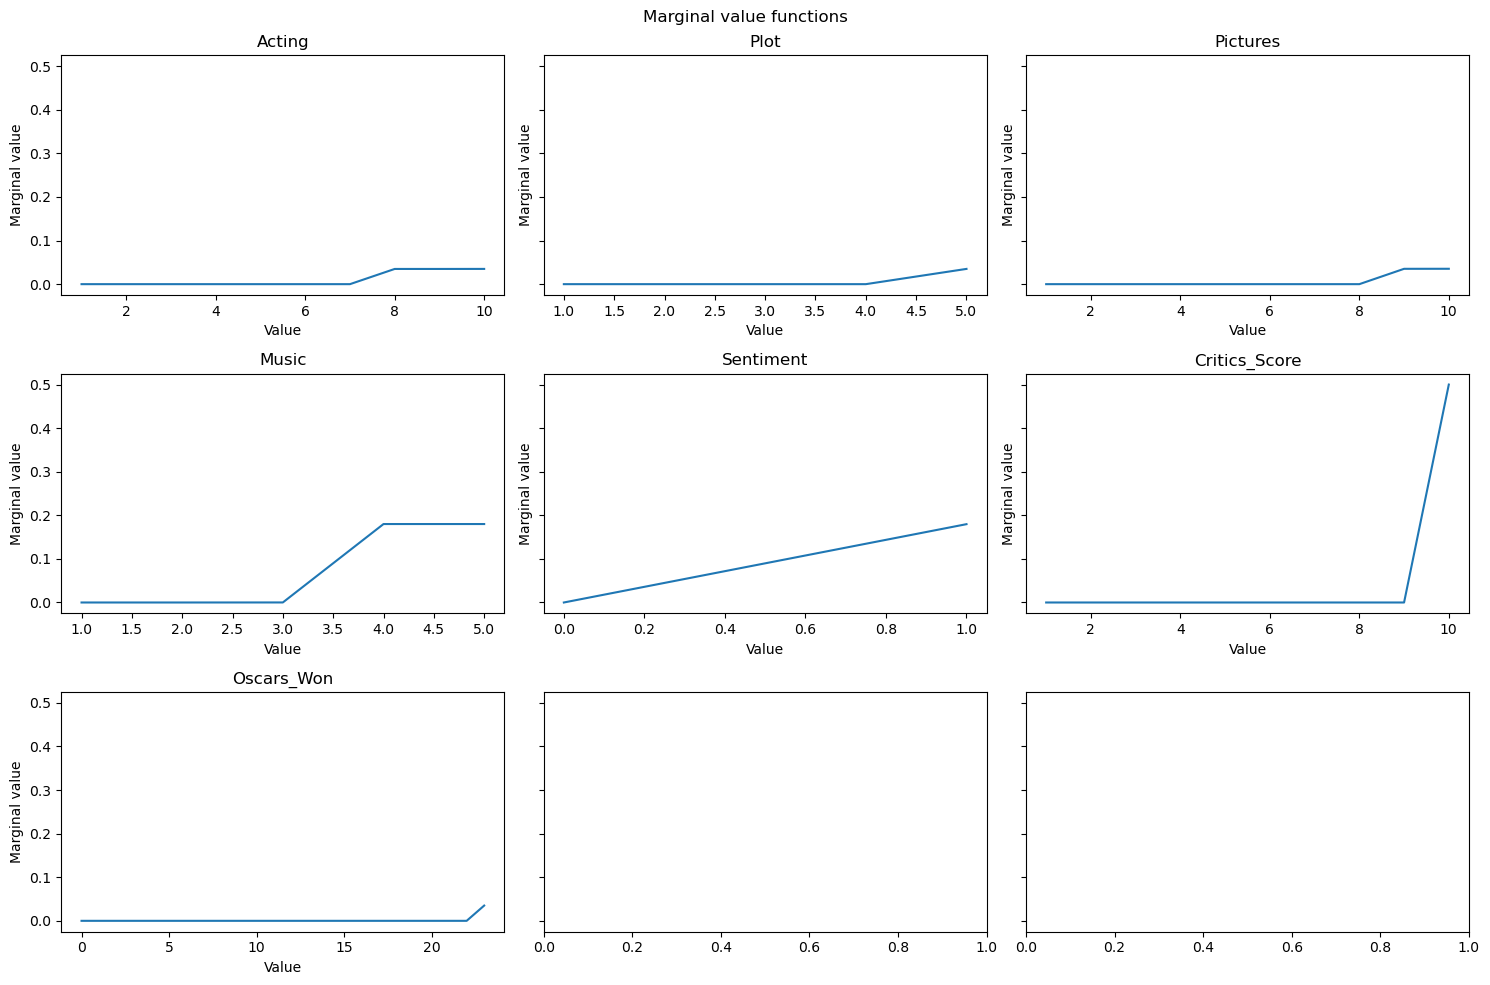

In [11]:
plot_marginal_value_functions(UTAresults, criteria, data)

Below we present the final UTA ranking of our movie dataset. The ranking is pretty much exactly as we thought it would look like. What is interesting is that the worst scoring movies are pretty close to the good ones in terms of their utility scores -- the absolute difference is not large. We believe this is because we intentionally added some pairwise comparisons between good and bad movies (like Forrest Gump and Catwoman) which are completely a flipside of what they should be. This is exactly the reason why, e.g., Forrest Gump has almost the same utility as the worst movies in the dataset like Birdemic.

In [12]:
uta_ranking = get_ranking(UTAresults, data)
uta_ranking

[('Shutter_Island', 0.3201),
 ('The_Lord_of_the_Rings:_The_Return_of_the_King', 0.2852),
 ('Dune_2', 0.2852),
 ('The_Prestige', 0.2852),
 ('Se7en', 0.285),
 ('Inception', 0.2502),
 ('Fight_Club', 0.2502),
 ('The_Dark_Knight', 0.2501),
 ('Gladiator', 0.2501),
 ('The_Godfather', 0.25),
 ("Schindler's_List", 0.25),
 ('Whiplash', 0.25),
 ('The_Godfather_Part_II', 0.25),
 ('The_Silence_of_the_Lambs', 0.25),
 ('Goodfellas', 0.25),
 ('The_Shawshank_Redemption', 0.2499),
 ('Pulp_Fiction', 0.2499),
 ('The_Green_Mile', 0.2499),
 ('The_Departed', 0.2499),
 ('Forrest_Gump', 0.2149),
 ('The_Matrix', 0.2149),
 ('Fifty_Shades_of_Grey', 0.2148),
 ('Transformers:_Revenge_of_the_Fallen', 0.2148),
 ('Gigli', 0.2147),
 ('The_Room', 0.2147),
 ('Jack_and_Jill', 0.2147),
 ('Birdemic:_Shock_and_Terror', 0.2147),
 ('Battlefield_Earth', 0.2147),
 ('Superbabies:_Baby_Geniuses_2', 0.2147),
 ('Foodfight!', 0.2147),
 ('Batman_&_Robin', 0.1798),
 ('Catwoman', 0.1797)]

Kendall matrix of UTA ranking

In [30]:
calulate_kendall_matrix(uta_ranking, pretty_print=True)

,Catwoman,Batman_&_Robin,Gigli,The_Room,Jack_and_Jill,Birdemic:_Shock_and_Terror,Battlefield_Earth,Superbabies:_Baby_Geniuses_2,Foodfight!,Fifty_Shades_of_Grey,...,Goodfellas,The_Dark_Knight,Gladiator,Inception,Fight_Club,Se7en,The_Lord_of_the_Rings:_The_Return_of_the_King,Dune_2,The_Prestige,Shutter_Island
Catwoman,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Batman_&_Robin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gigli,0.0,0.0,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The_Room,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.5,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jack_and_Jill,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Birdemic:_Shock_and_Terror,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Battlefield_Earth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Superbabies:_Baby_Geniuses_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Foodfight!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fifty_Shades_of_Grey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***
# AHP

In [14]:
tree_df = pd.read_csv('data/ahp/hierarchy.csv')
hierarchy_directory = 'data/ahp/'
data_df = pd.read_csv('data/data.csv')
from project2.ahp.ahp import *

## Criteria hierarchy

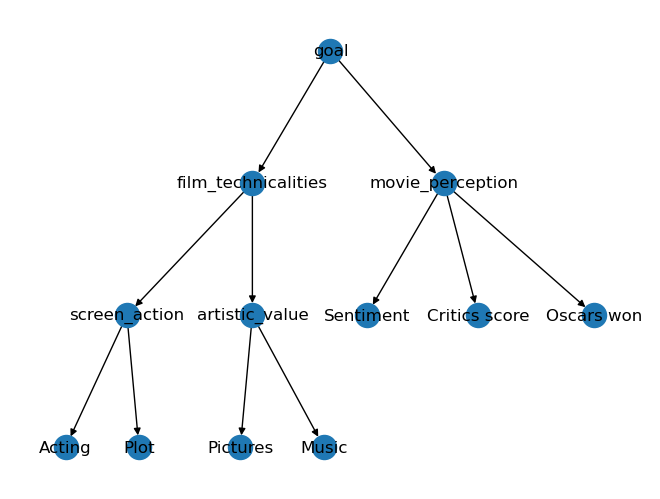

In [15]:
plot_tree(tree_df)

In [16]:
loaded_matrices = load_comparison_matrices(hierarchy_directory)
eigenvectors = {}
for node, matrix in loaded_matrices.items():
    eigenvectors[node] = approximate_principal_eigenvector(matrix.values)

## Tree with calculated weightss

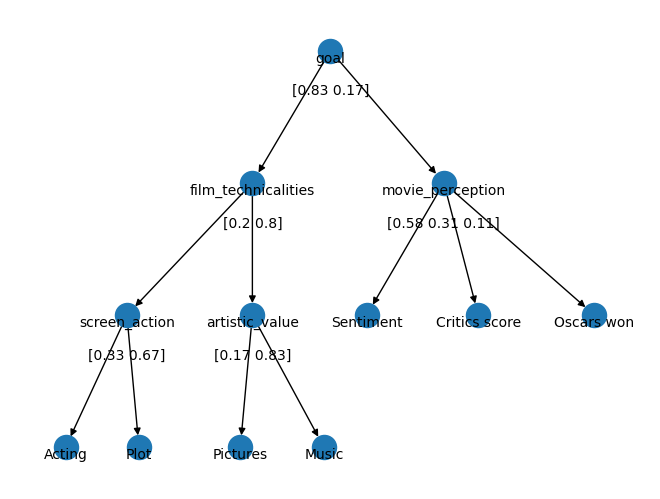

In [17]:
plot_tree_with_weights(tree_df, eigenvectors)

## Comparison matrices & Relative Consistency Indices

In [18]:
for node, matrix in loaded_matrices.items():
    print(node)
    cr = calculate_consistency_ratio(matrix)
    print(f"Relative consistency index: {cr}")
    ans = "Satisfactory" if cr < 0.1 else "Unsatisfactory"
    print(f"Consistency: {ans}")
    print(matrix)
    print()

movie_perception_comparison
Relative consistency index: (0.0029145591970555487+0j)
Consistency: Satisfactory
   Sentiment  Critics Score  Oscars Won
0        1.0          2.000         5.0
1        0.5          1.000         3.0
2        0.2          0.333         1.0

film_technicalities_comparison
Relative consistency index: 0.0
Consistency: Satisfactory
   screen_action  artistic_value
0            1.0            0.25
1            4.0            1.00

screen_action_comparison
Relative consistency index: 0.0
Consistency: Satisfactory
   Acting  Plot
0     1.0   0.5
1     2.0   1.0

goal_comparison
Relative consistency index: 0.0
Consistency: Satisfactory
   film_technicalities  movie_perception
0                  1.0               5.0
1                  0.2               1.0

artistic_value_comparison
Relative consistency index: 0.0
Consistency: Satisfactory
   Pictures  Music
0       1.0    0.2
1       5.0    1.0



We did not perform pairwise comparisons between alternatives for each leaf criteria (lowest level criteria) because we would for each one of those have large comparison matrices (7 criteria, 33x33). Instead, we treated them as quantitative criteria and calculated their weights directly. 

The method was suggested at our Decision Analysis lectures at the slide visible below:

![](quantitative_info_slide.png)

In our opinion this is much more convinient approach for decisionmakers, as they do not have to perform large amounts of comparisons which would be exhausting and keeping them consistend would be hard. Instead, because we had quantitative evaluations from previous project, we went with this approach.

## Dealing with inconsistency

As stated in the project description, we provided one inconsistent comparison matrix in our problem. This matrix was comparion of movie_perception children which are:
- Sentiment
- Critics score
- Oscars won

In [19]:
inconsistent_matrix = loaded_matrices['movie_perception_comparison']
inconsistent_matrix

,Sentiment,Critics Score,Oscars Won
0,1.0,2.000,5.0
1,0.5,1.000,3.0
2,0.2,0.333,1.0


Here we calculated the principal eigenvector with the power method:

In [20]:
inconsistent_matrix_weights = approximate_principal_eigenvector(inconsistent_matrix.values)
inconsistent_matrix_weights

array([0.58157465, 0.30900373, 0.10942162])

Given those weights, we recreated the original matrix A:

In [21]:
recreated_matrix = recreate_matrix_from_weights(inconsistent_matrix_weights)
recreated_matrix

array([[1.        , 1.88209588, 5.31498872],
       [0.53132256, 1.        , 2.82397341],
       [0.18814715, 0.35411098, 1.        ]])

And compared it with the matrix provided by DM:

In [22]:
differece_matrix = inconsistent_matrix - recreated_matrix
differece_matrix

,Sentiment,Critics Score,Oscars Won
0,0.000000,0.117904,-0.314989
1,-0.031323,0.000000,0.176027
2,0.011853,-0.021111,0.000000


We can see that the largest difference between the matrices is between how much times the Sentiment is better than Oscars won (-0.31).

## Final ranking obtained from AHP

In [23]:
ahp_ranking = perform_ahp(data_df, loaded_matrices, tree_df)

/home/ignacy/putai/sem6/decision_analysis/decision-analysis/project2/ahp/ahp.py:171: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  criterion_score = row[i]


AHP ranking also doesn't have any surprises. Best and worst alternatives are exactly as expected. 

In [24]:
ahp_ranking = sorted(ahp_ranking, key=lambda x: x[1], reverse=True)
ahp_ranking

[('The Lord of the Rings: The Return of the King', 0.228525881785606),
 ("Schindler's List", 0.1716782997998768),
 ('The Shawshank Redemption', 0.17142462146400672),
 ('The Godfather Part II', 0.16356588490780094),
 ('Forrest Gump', 0.15189254706828356),
 ('The Silence of the Lambs', 0.14556402493702902),
 ('Gladiator', 0.14018314535888185),
 ('Inception', 0.13262628602236148),
 ('The Matrix', 0.13151517491125037),
 ('The Green Mile', 0.1277817358522092),
 ('The Departed', 0.1277817358522092),
 ('The Godfather', 0.12510434644626245),
 ('Whiplash', 0.1245487908907069),
 ('The Prestige', 0.10765804203104612),
 ('The Dark Knight', 0.10642970482578029),
 ('Goodfellas', 0.09890776524968126),
 ('Fight Club', 0.09386287034113759),
 ('Pulp Fiction', 0.09347273976355207),
 ('Shutter Island', 0.07705524012571346),
 ('Se7en', 0.07675336290602802),
 ('Dune 2', 0.07590920925418101),
 ('Batman & Robin', 0.042240075874965685),
 ('Catwoman', 0.04092943233596645),
 ('Fifty Shades of Grey', 0.0340453546

***
# Comparison

In [25]:
# To spare some space in the report, we load the results of PROMETHEE from a csv file generated using report notebook from previous project
promethee_ranking = [(x,y) for x, y in list(pd.read_csv('results/promethee/ranking_prom2_overall.csv').to_numpy())]
promethee_ranking

[('The Lord of the Rings: The Return of the King', 15.318181818181818),
 ('The Shawshank Redemption', 12.181818181818183),
 ("Schindler's List", 12.181818181818183),
 ('The Godfather Part II', 12.000000000000002),
 ('The Silence of the Lambs', 11.545454545454549),
 ('Inception', 11.113636363636363),
 ('Gladiator', 10.477272727272728),
 ('Forrest Gump', 10.318181818181818),
 ('The Matrix', 10.295454545454543),
 ('The Green Mile', 9.90909090909091),
 ('The Departed', 9.90909090909091),
 ('The Godfather', 9.045454545454549),
 ('Whiplash', 8.431818181818183),
 ('The Prestige', 5.863636363636363),
 ('The Dark Knight', 5.5227272727272725),
 ('Dune 2', 4.977272727272728),
 ('Fight Club', 4.613636363636363),
 ('Goodfellas', 4.340909090909092),
 ('Pulp Fiction', 4.340909090909092),
 ('Se7en', 3.772727272727273),
 ('Shutter Island', 3.772727272727273),
 ('Batman & Robin', -12.863636363636363),
 ('Fifty Shades of Grey', -13.931818181818183),
 ('Transformers: Revenge of the Fallen', -13.9318181818

<div style="background-color: #993300; color: white; text-align: center">
    <p>Comparison of UTA, AHP, PROMETHEEII rankings using kendalls tau </p>
</div>

In [26]:
# UTA vs PROMETHEE
compute_kendalls_tau(uta_ranking, promethee_ranking)

0.9516129032258065

In [27]:
# AHP vs PROMETHEE
compute_kendalls_tau(ahp_ranking, promethee_ranking)

0.9949596774193549

In [28]:
# UTA vs AHP
compute_kendalls_tau(uta_ranking, ahp_ranking)

0.9485887096774194

We can see that they all are pretty similar to each other. AHP and PROMETHEE are almost perfectly similar -- if we compare the latter to the former ranking, only 4 movies are displaced, but they all are next to each other (Inception, Gladiator, Forrest Gump, The Silence of the Lambs). Their comprehensive flows are just a bit different and that's what causing that difference.   

From the theorethical perspective it is interesting that all rankings are that similar. For UTA we have added a bunch of new pairwise comparisons, which could potentially displace more alternatives compared to, e.g., PROMETHEE ranking. For AHP we calculated weights using method which accesses qualitative information in our dataset (our scoring of the alternatives). The only input we had in AHP was deciding which criteria are more important than others (comparison matrices) in our hierarchy (which also was arbitrailry defined by us). Our prior was, since we weren't aiming to achieve the same rankings on purpose, that our "local" decisions for UTA and AHP will influence the resulting rankings more. This hasn't happend though. The most resonable answer to "why?" is, in our opinion, that our dataset doesn't have much diversity. We included either "good" or "bad" movies, kind of forgetting about those that are "mid". Therefore, it is impossible to flip the ranking, as well as in general it is difficult to score those movies differently. We believe that this is the main cause for these rankings being so similar.   

In [29]:
# Create pandas with rankings
df_uta = pd.DataFrame(uta_ranking, columns=['Alternative', 'Ranking UTA'])
df_uta['Alternative'] = df_uta['Alternative'].apply(lambda x: x.replace('_', ' ')) # Remove underscores added by UTA
df_ahp = pd.DataFrame(ahp_ranking, columns=['Alternative', 'Ranking AHP'])
df_promethee = pd.DataFrame(promethee_ranking, columns=['Alternative', 'Ranking PROMETHEE'])

# Merge rankings
df = df_uta.merge(df_ahp, on='Alternative').merge(df_promethee, on='Alternative')

# Sort by UTA ranking
df = df.sort_values('Ranking AHP', ascending=False)

df


,Alternative,Ranking UTA,Ranking AHP,Ranking PROMETHEE
1,The Lord of the Rings: The Return of the King,0.2852,0.228526,15.318182
10,Schindler's List,0.2500,0.171678,12.181818
15,The Shawshank Redemption,0.2499,0.171425,12.181818
12,The Godfather Part II,0.2500,0.163566,12.000000
19,Forrest Gump,0.2149,0.151893,10.318182
13,The Silence of the Lambs,0.2500,0.145564,11.545455
8,Gladiator,0.2501,0.140183,10.477273
5,Inception,0.2502,0.132626,11.113636
20,The Matrix,0.2149,0.131515,10.295455
17,The Green Mile,0.2499,0.127782,9.909091


In [39]:
# Get top 2 best  alternatives for each method

for method in ['UTA', 'AHP', 'PROMETHEE']:
    print(f'Top 2 alternatives for {method}:')
    print(df.sort_values(f'Ranking {method}', ascending=False).head(2)['Alternative'].to_list())

Top 2 alternatives for UTA:
['Shutter Island', 'The Lord of the Rings: The Return of the King']
Top 2 alternatives for AHP:
['The Lord of the Rings: The Return of the King', "Schindler's List"]
Top 2 alternatives for PROMETHEE:
['The Lord of the Rings: The Return of the King', "Schindler's List"]


In [40]:
for method in ['UTA', 'AHP', 'PROMETHEE']:
    print(f'Top 2 worst alternatives for {method}:')
    print(df.sort_values(f'Ranking {method}').head(2)['Alternative'].to_list())

Top 2 worst alternatives for UTA:
['Catwoman', 'Batman & Robin']
Top 2 worst alternatives for AHP:
['Foodfight!', 'The Room']
Top 2 worst alternatives for PROMETHEE:
['Foodfight!', 'The Room']


We have desribed in the previous markdown box what in our opinion mattered in these rankings being a bit different but still incredibly similar. Here we also showed top 2 best and worst alternatives, and in general they are basically the same. For the worst ones we have 2x Foodfight + The Room and 1x Catwoman + Batman & Robin -- this difference is most probably caused by AHP's comparison matrices. For the top ones situation is analogical.